In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping

## Préparation des données

Le fichier _simulations.csv_ contient 10000 observations de trois variables d'entrée (trois premières colonnes) et des huit sorties générées par ces dernières via un modèle complexe (huit dernières colonnes).

Le but de l'exercice est d'ajuster au mieux un réseau de neurones afin de retrouver les valeurs d'entrée à partir des valeurs de sortie.

In [14]:
data = pd.read_csv("simulations.csv", header=None)
data.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.120964,0.035158,0.618706,0.0,0.0,0.0,0.0,0.0,0.134850,0.095695,52.411846,46.665506,0.456857,0.498308,0.462544,0.569043
1,0.157933,0.077691,0.614342,0.0,0.0,0.0,0.0,0.0,0.174525,0.118662,55.276823,47.986155,0.467475,0.473695,0.324767,0.457710
2,0.104400,0.064752,0.526321,0.0,0.0,0.0,0.0,0.0,0.130938,0.087290,57.602196,49.147401,0.583165,0.383176,0.428328,0.528848


In [15]:
# Les huit dernières colonnes correspondent à l'output
sortie = data.iloc[:, 8:]
sortie.head(3)

,8,9,10,11,12,13,14,15
0,0.134850,0.095695,52.411846,46.665506,0.456857,0.498308,0.462544,0.569043
1,0.174525,0.118662,55.276823,47.986155,0.467475,0.473695,0.324767,0.457710
2,0.130938,0.087290,57.602196,49.147401,0.583165,0.383176,0.428328,0.528848


In [16]:
# Les trois premières colonnes correspondent à l'input
entree = data.iloc[:, :3]
entree.head(3)

,0,1,2
0,0.120964,0.035158,0.618706
1,0.157933,0.077691,0.614342
2,0.104400,0.064752,0.526321


On sélectionne les 8000 premières obervations pour l'apprentissage et les 2000 restantes pour tester notre modèle.

In [17]:
X_train, X_test = sortie.iloc[:8000, :].to_numpy(), sortie.iloc[8000:, :].to_numpy()
y_train, y_test = entree.iloc[:8000, :].to_numpy(), entree.iloc[8000:, :].to_numpy()

## Recherche d'une architecture de réseau optimale sous Keras

Après de nombreux essais, nous avons opté pour un réseau relativement simple dans sa structure, contenant 8 couches cachées de 100 neurones chacune.
Le nombre maximal d'epochs est fixé à 500 pour être sûr obtenir de bons résultats sans rallonger excessivement le temps de calcul, dans la mesure où nous avons opté pour un mini-batch. 

Dans cette version, on a ajouté un callback `EarlyStopping()` qui interrompt l'ajustement du réseau lorsque la MAPE ne s'est pas améliorée pendant 20 epochs consécutives : on raccourcit ainsi le temps nécessaire à la réexécution sans trop nuire au résultat.

In [33]:
# On se laisse la possibilité de tester différents taux d'apprentissage en explicitant l'algorithme d'optimisation.
opti = keras.optimizers.Adam(learning_rate=0.0001)

# Le réseau contient 8 couches cachées de 100 neurones chacune.
# On recourt à la fonction relu pour l'activation des couches cachées et à l'identité pour la couche de sortie
reseau = keras.Sequential([
    layers.Input(shape = (8,)),
    # Couches cachées
    layers.Dense(100, kernel_initializer = "normal", activation = "relu"),
    layers.Dense(100, kernel_initializer = "normal", activation = "relu"),
    layers.Dense(100, kernel_initializer = "normal", activation = "relu"),
    layers.Dense(100, kernel_initializer = "normal", activation = "relu"),
    layers.Dense(100, kernel_initializer = "normal", activation = "relu"),
    layers.Dense(100, kernel_initializer = "normal", activation = "relu"),
    layers.Dense(100, kernel_initializer = "normal", activation = "relu"),
    layers.Dense(100, kernel_initializer = "normal", activation = "relu"),
    # Couche de sortie
    layers.Dense(3, kernel_initializer = "normal", activation = "linear"),
])

# On définit ici l'erreur moyenne quadratique classique comme fonction de perte.
# Le MAPE est indiqué comme métrique pour mesurer la qualité de l'estimation et vérifier l'absence de sur-apprentissage grâce aux données test.
reseau.compile(loss = 'mean_squared_error',
               optimizer = opti,
               metrics = 'mean_absolute_percentage_error')

evol = reseau.fit(X_train, y_train,
                  epochs = 500,
                  batch_size = 32,
                  validation_data = (X_test, y_test),
                  verbose = 0,
                  callbacks = EarlyStopping(monitor = 'mean_absolute_percentage_error',
                                            patience = 20,
                                            restore_best_weights = True)
                 )

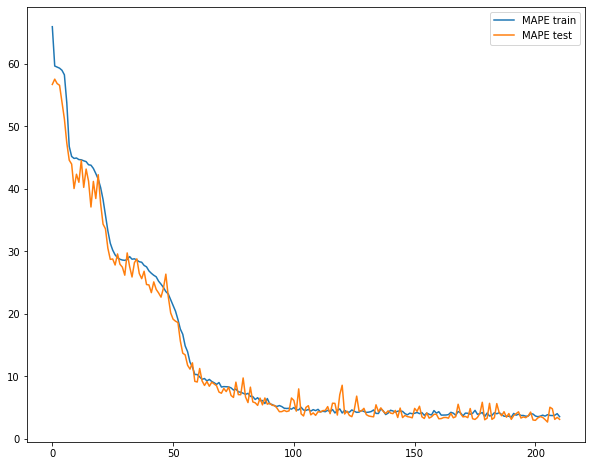


MSE à la dernière itération : 5.7259319873992354e-05

MAPE à la dernière itération : 3.11 %


In [34]:
plt.figure(figsize=(10,8))
plt.plot(evol.history['mean_absolute_percentage_error'], label='MAPE train')
plt.plot(evol.history['val_mean_absolute_percentage_error'], label='MAPE test')
plt.legend()
plt.show()

mse, pmea = reseau.evaluate(X_test, y_test, verbose=0)
print(f'\nMSE à la dernière itération : {mse}\n\nMAPE à la dernière itération : {round(pmea, 2)} %')

__Lors des 100 premières itérations, la MAPE décroît relativement vite pour atteindre environ 5%.__

__Les 400 itérations suivantes font doucement chuter la métrique vers 2-3%, ce qui correspond à notre meilleur score.__